# Figure 1

This notebook contains the functions used to construct Figure 1. 

The figure contains 3 panels:

- a) Coverage of H3K4me3 and H3k36me3 peaks in primary cells of normal colon mucosa (E075) and coverage of nucleosomes in GM12878 (lymphoblastoid cell line), splitting exons and introns by position.
- b) Difference of exonic and intronic coverage of each histon mark available on Roadmap against the median coverage across gene exons.
- c) Exons and flanking introns coverage of H3K36me3 peaks in primary cells of normal colon mucosa (E075).


---

The data required for each panel is saved in a file and loaded before plotting. The reason is that, once the data has been generated, the plot can be created and modified without recomputing the data.

In [1]:
import os
import math
from os import path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pybedtools
import statsmodels.stats.multitest as smm
from scipy.stats import mannwhitneyu
from tqdm import tqdm

from python_scripts.plot_functions import config_plot_params

In [2]:
%matplotlib inline

In [3]:
config_plot_params()

## Input


### Included files

Files in the **data** directory. There is more information about them in the ``README`` file in that folder.

- *intron_coords*: file with the coordinates of the introns  
- *middle_exons_coords*: file with the coordinates of the middle exons
- *exons_coords*: file with the coordinates of all exons (not only middle) of genes with at least 5 exons
- *nucl_coords_path*: file with the coordinates of the nucleosomes


### Not included files

These files are not included. There is more information about them in the ``README`` file located in the **non_provided_data** folder.

- histone_data_folder: path to folder where the histon marks data files are. This notebook makes use of the peaks information (files with the ``.narrowPeak.gz`` extension e.g. ``E075-H3K36me3.narrowPeak.gz``)


In [5]:
# Included
intron_coords = 'data/coordinates/genes_intron_coords.bed.gz'
middle_exons_coords = 'data/coordinates/genes_middle_exon_coords.bed.gz'
exons_coords = 'data/coordinates/genes_exon_coords_filtered.bed.gz'
nucl_coords_path = 'data/nucleosome_coords.bed'

# Not included
histone_data_folder = 'non_provided_data/histonmarks/'

## Stratify exons

For a user defined set of exons (first, second, ..., last), compute the number of bases covered by each chromatine feature. The data processing corresponds to the section **Chromatin structural features** in the paper.

The introns are defined as the regions between exons. E.g. the first intron is represented by the bases between the first and second exons.

When computing the bases with histon marks, only the exons and introns with a length higher or equal to the 25th percentile are used, and for those, only the central bases are taken into account.

The same process is repeated for the nucleosomes.

In [6]:
def compute_exons_per_gene(exons_position_df):
    """Given a df numbered exons per gene, get the total number of exons per gene"""
    
    my_exons_per_gene = list()

    for index, my_df in exons_position_df.groupby(3):
        my_exons_per_gene.append([index, my_df[8].max()])
        
    my_exons_per_gene_df = pd.DataFrame(my_exons_per_gene)
    my_exons_per_gene_df.columns = ['gene', 'n_exons']

    return my_exons_per_gene_df

In [7]:
def overlap_with_his_marks(my_coords_df, histon_mark_bed):
    """
    The size is computed as the value of the 25th percentile.
    Segments below are discarded.
    For the rest, they are centered and only positions around the centre an within 
    a distance of half the size are considered.
    """

    my_coords_df['size'] = (my_coords_df['end'] - my_coords_df['start'])

    lower_quart = my_coords_df['size'].describe()['25%']

    filtered_coords_df = my_coords_df[my_coords_df['size'] >= lower_quart].copy()  # Remove short segments
    
    filtered_coords_df['middle_start'] = (filtered_coords_df['start'] + filtered_coords_df['size']/2)
    filtered_coords_df['middle_start'] = filtered_coords_df.apply(lambda x: math.floor(x['middle_start']), axis=1)
    filtered_coords_df['middle_end'] = filtered_coords_df['middle_start'] + 1

    filtered_coords_df['region_start'] = filtered_coords_df['middle_start'] - math.floor(lower_quart/2)
    filtered_coords_df['region_end'] = filtered_coords_df['middle_end'] + math.floor(lower_quart/2)
    filtered_coords_bed = pybedtools.BedTool.from_dataframe(filtered_coords_df[
            ['chr', 'region_start', 'region_end', 'ensembl', 'size']
        ])
    
    my_histon_intersec_bed = filtered_coords_bed.intersect(histon_mark_bed)

    my_histon_intersec_df = pd.read_table(my_histon_intersec_bed.fn, names=['chr', 'start', 'end', 'ensembl', 'size'])

    total_bases = sum(filtered_coords_df['region_end'] - filtered_coords_df['region_start'])
    overlapping_bases = sum(my_histon_intersec_df['end'] - my_histon_intersec_df['start'])

    n_seqs = len(filtered_coords_df)
    
    return overlapping_bases, total_bases, lower_quart, n_seqs

In [8]:
exons_position_df = pd.read_csv(exons_coords, sep='\t', header=None)
my_exons_per_gene_df = compute_exons_per_gene(exons_position_df)
max_n_exons = my_exons_per_gene_df['n_exons'].max()

exons_position_bed = pybedtools.BedTool.from_dataframe(exons_position_df)

# Get last and second last exons
last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9] == 'last'])
others_than_last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9]!='last'])
last_bed = last_bed.merge(c='6,8', o='distinct')
last_bed = last_bed.intersect(others_than_last_bed, wo=True, sorted=True, v=True)  # drop all segment that overlap and are classified as last and any other category 
second_last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9] == 'secondlast'])
others_than_second_last_bed = pybedtools.BedTool.from_dataframe(exons_position_df[exons_position_df.loc[:, 9]!='secondlast'])
second_last_bed = second_last_bed.merge(c='6,8', o='distinct')
second_last_bed = second_last_bed.intersect(others_than_second_last_bed, wo=True, sorted=True, v=True)  # drop all segment that overlap and are classified as last and any other category 
second_and_last_bed = pybedtools.BedTool.from_dataframe(pd.concat([
        pd.read_table(last_bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl']),
        pd.read_table(second_last_bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl'])
    ])).sort().merge()


# Get the nucleosomes coordinates
nucl_coords_df = pd.read_csv(nucl_coords_path, sep='\t', header=None)
nucl_coords_df = nucl_coords_df[nucl_coords_df[3] >= 2.5]
nucl_coords_df = nucl_coords_df[[0,1,2]]
nucl_coords_df.columns = ['chr', 'start', 'end']
# expand to cover the 147 bases of the nucleosome
nucl_coords_df['start'] = nucl_coords_df['start'] - 73
nucl_coords_df['end'] = nucl_coords_df['end'] + 73
nucl_coords_df = nucl_coords_df[~nucl_coords_df['start'] < 0]

nucleosomes_bed = pybedtools.BedTool.from_dataframe(nucl_coords_df)
   
    
my_bins = [[1],[2],[3],[4],[5],[6],[7],[8],[9],[10],[11,15],[16,20],[21,40],[41,100]]
# Bins of the exons positions to be grouped

exon_position_results = list()


for my_exon_position in my_bins:

    print(my_exon_position)
    
    if len(my_exon_position) == 1:
        current_and_next_pos = [my_exon_position[0], my_exon_position[0]+1]
    else:
        current_and_next_pos = list(range(min(my_exon_position), max(my_exon_position)+1)) 
    
    conc_exons_df = pd.DataFrame()
    
    # Take current position exonic coordinates plus the following exon coordinates
    # In order to be able to define the coordinates of the intron following the current exon
    
    for my_pos in current_and_next_pos:  
        
        df = exons_position_df[exons_position_df.loc[:, 8] == my_pos]
        
        bed = pybedtools.BedTool.from_dataframe(df)
        bed = bed.merge(c='6,8', o='distinct')
        bed = bed.intersect(exons_position_bed, wo=True, sorted=True)
        bed = bed.merge(c='4,5,14', o='distinct')
        
        my_position_df = pd.read_table(bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl', 'position'])
        
        my_position_df = my_position_df[my_position_df['position'] == str(my_pos)]

        conc_exons_df = pd.concat([conc_exons_df, my_position_df])
        
    my_position_bed = pybedtools.BedTool.from_dataframe(conc_exons_df)
    
    # Remove segmets that overlap with last or second last exons
    inter_my_position_bed = my_position_bed.intersect(second_and_last_bed, wao=True)
    inter_my_position_df = pd.read_table(inter_my_position_bed.fn, names = 
                                         ['chr', 'start', 'end', 'strand', 'ensembl', 'position', 'chr_last', 'start_last', 'end_last', 'overlap']
                                        )
    inter_my_position_df = inter_my_position_df[inter_my_position_df['overlap'] == 0][['chr', 'start', 'end', 'strand', 'ensembl', 'position']]
    
    conc_exons_df = inter_my_position_df.copy()

    # Get the coordinates of the introns as the coordinates between the exons
    intron_coords_lol = list()
    for index, my_df in conc_exons_df.groupby('ensembl'):

        if len(set(my_df.position)) > 1:

            intron_chr = my_df[0:1].chr.values[0]
            intron_start = min(my_df.end)
            intron_end = max(my_df.start)
            intron_ensembl = my_df[0:1].ensembl.values[0]

            my_intron_row = [intron_chr, intron_start, intron_end, intron_ensembl]
            intron_coords_lol.append(my_intron_row)
            
    intron_coords_df = pd.DataFrame(intron_coords_lol)
    intron_coords_bed = pybedtools.BedTool.from_dataframe(intron_coords_df)

    # Remove the exons that are in the middle
    filtered_intron_coords_bed = intron_coords_bed.subtract(exons_position_bed)  # Ensure that the positions do not belong to any exon

    filtered_intron_coords_df = pd.read_table(filtered_intron_coords_bed.fn, names=['chr', 'start', 'end', 'ensembl'])

    # Get rid of the extra exon we included to be able to compute the corresponding intron
    filtered_exons_coords_df = conc_exons_df[conc_exons_df['position'].isin(my_exon_position)]
    filtered_exons_coords_df = filtered_exons_coords_df[['chr', 'start', 'end', 'ensembl']]
    
    pos_str = str(my_exon_position).replace('[', '').replace(']', '').replace(', ', '-').replace(',', '-')

    # For each histon mark and cell line compute the total bases and overlapping bases in intron and exons
    # according to the criteria in overlap_with_his_marks
    for file in os.listdir(histone_data_folder):
        if file.endswith(".narrowPeak.gz"):
            try:
                hist_mark_path = path.join(histone_data_folder, file)
                cell_line = file.split('.')[0].split('-')[0]
                hist_mark = file.split('.')[0].split('-')[1]                
                my_histon_cell = cell_line + '-' + hist_mark
                hist_mark_df = pd.read_csv(hist_mark_path, sep='\t', header=None)
                histon_mark_bed = pybedtools.BedTool.from_dataframe(hist_mark_df[[0,1,2]])
   
            except:
                print("Problem with ", file)
                continue

            overlapping_bases, total_bases, lower_quart, n_seqs = \
                overlap_with_his_marks(filtered_exons_coords_df, histon_mark_bed)

            ex_row = ['exon', pos_str, my_histon_cell, overlapping_bases, total_bases, lower_quart, n_seqs]

            overlapping_bases, total_bases, lower_quart, n_seqs = \
                overlap_with_his_marks(filtered_intron_coords_df, histon_mark_bed)

            intr_row = ['intron', pos_str, my_histon_cell, overlapping_bases, total_bases, lower_quart, n_seqs]

            exon_position_results.append(ex_row)
            exon_position_results.append(intr_row)
            
    # Nucleosomes
    overlapping_bases, total_bases, lower_quart, n_seqs = \
                overlap_with_his_marks(filtered_exons_coords_df, nucleosomes_bed)

    ex_row = ['exon', pos_str, 'unk-nucleosomes', overlapping_bases, total_bases, lower_quart, n_seqs]

    overlapping_bases, total_bases, lower_quart, n_seqs = \
        overlap_with_his_marks(filtered_intron_coords_df, nucleosomes_bed)

    intr_row = ['intron', pos_str, 'unk-nucleosomes', overlapping_bases, total_bases, lower_quart, n_seqs]

    exon_position_results.append(ex_row)
    exon_position_results.append(intr_row)
            

# Repeat for last and second last exons
current_and_next_pos = ['secondlast', 'last']
conc_exons_df = pd.DataFrame()

print('Second last and last')

for my_pos in current_and_next_pos:
    
    df = exons_position_df[exons_position_df.loc[:, 9] == my_pos]
        
    bed = pybedtools.BedTool.from_dataframe(df)
    bed = bed.merge(c='6,8', o='distinct')
    bed = bed.intersect(exons_position_bed, wo=True, sorted=True)
    bed = bed.merge(c='4,5,15', o='distinct')

    my_position_df = pd.read_table(bed.fn, names=['chr', 'start', 'end', 'strand', 'ensembl', 'position'])

    my_position_df = my_position_df[my_position_df['position'] == str(my_pos)]

    conc_exons_df = pd.concat([conc_exons_df, my_position_df])

intron_coords_lol = list()

for index, my_df in conc_exons_df.groupby('ensembl'):

    if len(set(my_df.position)) > 1:

        intron_chr = my_df[0:1].chr.values[0]
        intron_start = min(my_df.end)
        intron_end = max(my_df.start)
        intron_ensembl = my_df[0:1].ensembl.values[0]

        if intron_start > intron_end:
            print(my_df)

        my_intron_row = [intron_chr, intron_start, intron_end, intron_ensembl]
        intron_coords_lol.append(my_intron_row)

intron_coords_df = pd.DataFrame(intron_coords_lol)
intron_coords_bed = pybedtools.BedTool.from_dataframe(intron_coords_df)

filtered_intron_coords_bed = intron_coords_bed.subtract(exons_position_bed)
filtered_intron_coords_df = pd.read_table(filtered_intron_coords_bed.fn, names=['chr', 'start', 'end', 'ensembl'])

filtered_last_exons_coords_df = conc_exons_df[conc_exons_df['position'] == 'last']
filtered_last_exons_coords_df = filtered_last_exons_coords_df[['chr', 'start', 'end', 'ensembl']]

filtered_seclast_exons_coords_df = conc_exons_df[conc_exons_df['position'] == 'secondlast']
filtered_seclast_exons_coords_df = filtered_seclast_exons_coords_df[['chr', 'start', 'end', 'ensembl']]

for file in os.listdir(histone_data_folder):
    if file.endswith(".narrowPeak.gz"):
        try:
            hist_mark_path = path.join(histone_data_folder, file)
            cell_line = file.split('.')[0].split('-')[0]
            hist_mark = file.split('.')[0].split('-')[1]
            my_histon_cell = cell_line + '-' + hist_mark
            hist_mark_df = pd.read_csv(hist_mark_path, sep='\t', header=None)
            histon_mark_bed = pybedtools.BedTool.from_dataframe(hist_mark_df[[0,1,2]])
        except:
            print("Problem with ", file)
            continue
            

        overlapping_bases, total_bases, lower_quart, n_seqs = \
            overlap_with_his_marks(filtered_seclast_exons_coords_df, histon_mark_bed)

        seclast_ex_row = ['exon', 'sec_last', my_histon_cell, overlapping_bases, total_bases, lower_quart, n_seqs]


        overlapping_bases, total_bases, lower_quart, n_seqs = \
            overlap_with_his_marks(filtered_last_exons_coords_df, histon_mark_bed)

        last_ex_row = ['exon', 'last', my_histon_cell, overlapping_bases, total_bases, lower_quart, n_seqs]

        overlapping_bases, total_bases, lower_quart, n_seqs = \
            overlap_with_his_marks(filtered_intron_coords_df, histon_mark_bed)

        intr_row = ['intron', 'last', my_histon_cell, overlapping_bases, total_bases, lower_quart, n_seqs]

        exon_position_results.append(seclast_ex_row)
        exon_position_results.append(last_ex_row)
        exon_position_results.append(intr_row)
        
# Nucleosomes
overlapping_bases, total_bases, lower_quart, n_seqs = \
            overlap_with_his_marks(filtered_seclast_exons_coords_df, nucleosomes_bed)
    
ex_row = ['exon', 'sec_last', 'unk-nucleosomes', overlapping_bases, total_bases, lower_quart, n_seqs] 
exon_position_results.append(ex_row)

overlapping_bases, total_bases, lower_quart, n_seqs = \
            overlap_with_his_marks(filtered_last_exons_coords_df, nucleosomes_bed)

ex_row = ['exon', 'last', 'unk-nucleosomes', overlapping_bases, total_bases, lower_quart, n_seqs]

overlapping_bases, total_bases, lower_quart, n_seqs = \
    overlap_with_his_marks(filtered_intron_coords_df, nucleosomes_bed)

intr_row = ['intron', 'last', 'unk-nucleosomes', overlapping_bases, total_bases, lower_quart, n_seqs]

exon_position_results.append(ex_row)
exon_position_results.append(intr_row)
        
    
exon_position_results_df = pd.DataFrame(exon_position_results)
exon_position_results_df.columns = ['region', 'position', 'hist_cell', 'covered_bp', 'total_bp', 'lower_quartile', 'n_elements']
exon_position_results_df['rate'] = exon_position_results_df['covered_bp']/exon_position_results_df['total_bp']

exon_position_results_df.to_csv(path.join('results', 'histon_mark_and_nucleosomes_per_position.tsv'), 
                                sep='\t', index=False)

[1]
[2]
[3]
[4]
[5]
[6]
[7]
[8]
[9]
[10]
[11, 15]
[16, 20]
[21, 40]
[41, 100]
Second last and last


## Scores

Compute the mean, median and standard deviation of the coverage of exons and introns. Additionally, the Mann–Whitney U test is also used to compute a p-value of the comparison of both distributions.

In [9]:
def return_cell(x):    
    return x['index'].split('-')[0]

def return_hist(x):    
    return x['index'].split('-')[1]

global_results_lol = list()

stratified_df = pd.read_csv(path.join('results', 'histon_mark_and_nucleosomes_per_position.tsv'), sep='\t')

stratified_df['cov'] = stratified_df['covered_bp']/stratified_df['total_bp']

# Analyse per pair of histon mark and cell line
for index, my_df in stratified_df.groupby('hist_cell'):
    
    exons_df = my_df[my_df['region'] == 'exon']
    introns_df = my_df[my_df['region'] == 'intron']
    
    exons_cov_mean = exons_df['cov'].mean()
    introns_cov_mean = introns_df['cov'].mean()
    total_cov_mean = my_df['cov'].mean()
    
    exons_cov_median = exons_df['cov'].median()
    introns_cov_median = introns_df['cov'].median()
    total_cov_median = my_df['cov'].median()
    
    exons_cov_std = exons_df['cov'].std()
    introns_cov_std = introns_df['cov'].std()
    total_cov_std = my_df['cov'].std()
    
    u, p_value = mannwhitneyu(exons_df['cov'], introns_df['cov'])
    
    results_row = [index, exons_cov_mean, introns_cov_mean, total_cov_mean,
                   exons_cov_median, introns_cov_median, total_cov_median, 
                   exons_cov_std, introns_cov_std, total_cov_std, u, p_value]

    global_results_lol.append(results_row)

global_results_df = pd.DataFrame(global_results_lol)
global_results_df.columns = ['index', 'exons_cov_mean', 'introns_cov_mean', 'total_cov_mean',
                   'exons_cov_median', 'introns_cov_median', 'total_cov_median', 
                   'exons_cov_std', 'introns_cov_std', 'total_cov_std', 'u', 'p_value']

global_results_df['cell_line'] = global_results_df.apply(lambda x: return_cell(x), axis=1)
global_results_df['hist_mark'] = global_results_df.apply(lambda x: return_hist(x), axis=1)

global_results_df['ex_in_mean_diff'] = global_results_df['exons_cov_mean'] - global_results_df['introns_cov_mean']
global_results_df['ex_in_mean_reat'] = global_results_df['exons_cov_mean']/global_results_df['introns_cov_mean']

global_results_df['ex_in_median_diff'] = global_results_df['exons_cov_median'] - global_results_df['introns_cov_median']
global_results_df['ex_in_median_reat'] = global_results_df['exons_cov_median']/global_results_df['introns_cov_median']

global_results_df['q_value'] = smm.multipletests(global_results_df['p_value'].tolist(), alpha=0.05, method='fdr_i', is_sorted=False, returnsorted=False)[1]

global_results_df.to_csv(path.join('results', 'score_per_histon_mark_and_nucleosome.tsv'), sep='\t', index=False)

### Panel a)

Coverage of H3K4me3 and H3K36me3 peaks in exons and introns of normal clon mucosa cells (E075) and nucleosome covered regions in lymphoblastoid cell line (GM12878).

Please note that in the paper we trimmed the Y-axis.

In [10]:
x_order = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11-15', '16-20', '21-40', '41-100']
def get_values_barplot(coverage_df, scores_df, histone):
    '''function to return the values for boxplot'''

    x_values = []
    x_labels = []
    x_colors = []
    box_plot_values = {}
    box_plot_values['exon'] = []
    box_plot_values['intron'] = []

    for x in x_order:
        for region in ['exon', 'intron']:

            row = coverage_df[(coverage_df['hist_cell']==histone) & (coverage_df['position']==x) & 
                                 (coverage_df['region']==region)][['covered_bp', 'total_bp']]

            if len(row)==0:
                print(x, region)
                break
                
            per_cov = row['covered_bp'].values[0]/row['total_bp'].values[0]

            x_values.append(per_cov)
            x_labels.append("%s %s" % (region, x))
            
            x_colors.append(rcolors[region])
            
            box_plot_values[region].append(per_cov)

    # Special cases:
    ## Second last exons
    row = coverage_df[(coverage_df['hist_cell']==histone) & (coverage_df['position']=='sec_last') & 
                         (coverage_df['region']=='exon')][['covered_bp', 'total_bp']]

    print(len(row))
    per_cov = row['covered_bp'].values[0]/row['total_bp'].values[0]

    x_values.append(per_cov)
    x_labels.append("%s second last" % ('exon'))
    box_plot_values['exon'].append(per_cov)
    x_colors.append(rcolors['exon'])

    ## Last intron and then exon
    for region in ['intron', 'exon']:

        row = coverage_df[(coverage_df['hist_cell']==histone) & (coverage_df['position']=='last') & 
                             (coverage_df['region']==region)][['covered_bp', 'total_bp']]

        if len(row)==0:
            print(x, region)
            break

        per_cov = row['covered_bp'].values[0]/row['total_bp'].values[0]

        x_values.append(per_cov)
        x_labels.append("%s %s" % (region, 'last'))
        
        box_plot_values[region].append(per_cov)
        x_colors.append(rcolors[region])
        
    # get the p-value to mention in the boxplot
    wpvalue = scores_df[scores_df['index']==histone]['p_value'].values[0]
        
    return x_values, x_labels, x_colors, box_plot_values, wpvalue

1
1
1
['exon 1', 'intron 1', 'exon 2', 'intron 2', 'exon 3', 'intron 3', 'exon 4', 'intron 4', 'exon 5', 'intron 5', 'exon 6', 'intron 6', 'exon 7', 'intron 7', 'exon 8', 'intron 8', 'exon 9', 'intron 9', 'exon 10', 'intron 10', 'exon 11-15', 'intron 11-15', 'exon 16-20', 'intron 16-20', 'exon 21-40', 'intron 21-40', 'exon 41-100', 'intron 41-100', 'exon second last', 'intron last', 'exon last']


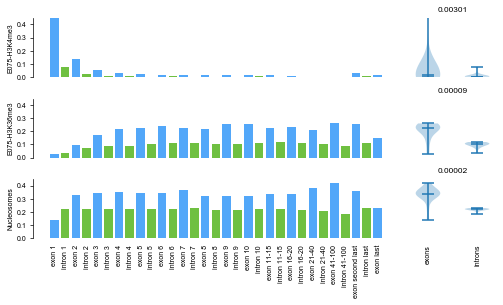

In [11]:
# Read data
coverage_df = pd.read_csv(path.join('results', "histon_mark_and_nucleosomes_per_position.tsv"), sep="\t")
coverage_df.drop_duplicates(inplace=True)
scores_df = pd.read_csv(path.join('results', "score_per_histon_mark_and_nucleosome.tsv"), sep="\t")
scores_df.drop_duplicates(inplace=True)

fig = plt.figure(figsize=(7, 4.25))

rcolors={'exon':'#52a7f9', 'intron':'#6fc041'}

axs=[]
NROW=3
NCOL=5

for row in range(0, NROW):
    axs.append(plt.subplot2grid((NROW, NCOL), (row, 0), colspan=4))
    axs.append(plt.subplot2grid((NROW, NCOL), (row, 4)))  

ymax=0.45 # ylimit
ymin=0


# first panel bar plot
count=0
for histone in ['E075-H3K4me3', 'E075-H3K36me3', 'Nucleosomes']:

    if histone != 'Nucleosomes':
        x_values, x_labels, x_colors, box_plot, wpvalue = get_values_barplot(coverage_df, scores_df, histone)
    else:
        x_values, x_labels, x_colors, box_plot, wpvalue = get_values_barplot(coverage_df, scores_df, 'unk-nucleosomes')

    # generate x tick count
    tmp_x = []
    for i in range(0, len(x_values)):
        tmp_x.append(i)
    
    # do the bar plot    
    axs[count].bar(tmp_x, x_values, color=x_colors)
    axs[count].set_ylim(ymin, ymax)
    # show the left spline
    for axis in ['right', 'top', 'bottom']:
        axs[count].spines[axis].set_visible(False)
    
    axs[count].yaxis.major.locator.set_params(nbins=5)
    axs[count].yaxis.set_ticks_position('left')
    axs[count].xaxis.set_ticks_position('none')
    axs[count].set_ylabel(histone)
    
    if histone == 'Nucleosomes':
        print(x_labels)
        axs[count].set_xticklabels(['', ''] + x_labels, rotation=90)
        axs[count].xaxis.major.locator.set_params(nbins=len(x_labels)*2)
        
    else:
        axs[count].axes.xaxis.set_ticklabels([])

    
    count+=1

    # first panel box plot
    flierprops = dict(marker='o', markersize=3, linestyle='none', mew=0.5) # outlier size
    medianprops = dict(linewidth=0.7)
    boxprops = capprops = whiskerprops = dict(linewidth=0.7) # outer linewidth
    
    #axs[count].boxplot([box_plot['exon'], box_plot['intron']], widths=(0.3, 0.3), flierprops=flierprops,
    #                  medianprops = medianprops, boxprops=boxprops, capprops=capprops, whiskerprops=whiskerprops)
    axs[count].violinplot([box_plot['exon'], box_plot['intron']],
                   showmeans=False,
                   showmedians=True, showextrema=True)
    axs[count].set_ylim(ymin, ymax)
    
    # show the left spline
    for axis in ['right', 'top', 'bottom', 'left']:
        axs[count].spines[axis].set_visible(False)

    axs[count].margins(0.05)
    axs[count].axhline(0, color='gray', lw=0.5)

    axs[count].yaxis.major.locator.set_params(nbins=8)
    axs[count].xaxis.set_ticks_position('none')
    axs[count].yaxis.set_ticks_position('none')
    axs[count].axes.yaxis.set_ticklabels([])
    axs[count].axes.xaxis.set_ticklabels([])
    
    if histone == 'Nucleosomes':
        axs[count].set_xticklabels(['', 'exons', 'introns'], rotation=90)

    axs[count].set_title("%.5f" % wpvalue)
    count+=1

plt.tight_layout()
plt.savefig(path.join('figures', 'figure1A.svg'), bbox_inches='tight' )
plt.show()

## Scores excluding first and last exons

Recompute the coverage excluding first and last exons.

In [12]:
def return_cell(x):    
    return x['index'].split('-')[0]

def return_hist(x):    
    return x['index'].split('-')[1]

global_results_lol = list()

stratified_df = pd.read_csv(path.join('results', 'histon_mark_and_nucleosomes_per_position.tsv'), sep='\t')
stratified_df = stratified_df[~((stratified_df['region'] == 'exon') & (stratified_df['position'].isin(['1'])))]
stratified_df = stratified_df[~((stratified_df['region'] == 'exon') & (stratified_df['position'].isin(['last'])))]

stratified_df['cov'] = stratified_df['covered_bp']/stratified_df['total_bp']

for index, my_df in stratified_df.groupby('hist_cell'):
    
    exons_df = my_df[my_df['region'] == 'exon']
    introns_df = my_df[my_df['region'] == 'intron']
    
    exons_cov_mean = exons_df['cov'].mean()
    introns_cov_mean = introns_df['cov'].mean()
    total_cov_mean = my_df['cov'].mean()
    
    exons_cov_median = exons_df['cov'].median()
    introns_cov_median = introns_df['cov'].median()
    total_cov_median = my_df['cov'].median()
    
    exons_cov_std = exons_df['cov'].std()
    introns_cov_std = introns_df['cov'].std()
    total_cov_std = my_df['cov'].std()
    
    u, p_value = mannwhitneyu(exons_df['cov'], introns_df['cov'])
    
    results_row = [index, exons_cov_mean, introns_cov_mean, total_cov_mean,
                   exons_cov_median, introns_cov_median, total_cov_median, 
                   exons_cov_std, introns_cov_std, total_cov_std, u, p_value]

    global_results_lol.append(results_row)

global_results_df = pd.DataFrame(global_results_lol)
global_results_df.columns = ['index', 'exons_cov_mean', 'introns_cov_mean', 'total_cov_mean',
                   'exons_cov_median', 'introns_cov_median', 'total_cov_median', 
                   'exons_cov_std', 'introns_cov_std', 'total_cov_std', 'u', 'p_value']

global_results_df['cell_line'] = global_results_df.apply(lambda x: return_cell(x), axis=1)
global_results_df['hist_mark'] = global_results_df.apply(lambda x: return_hist(x), axis=1)

global_results_df['ex_in_mean_diff'] = global_results_df['exons_cov_mean'] - global_results_df['introns_cov_mean']
global_results_df['ex_in_mean_reat'] = global_results_df['exons_cov_mean']/global_results_df['introns_cov_mean']

global_results_df['ex_in_median_diff'] = global_results_df['exons_cov_median'] - global_results_df['introns_cov_median']
global_results_df['ex_in_median_reat'] = global_results_df['exons_cov_median']/global_results_df['introns_cov_median']

global_results_df['q_value'] = smm.multipletests(global_results_df['p_value'].tolist(), alpha=0.05, method='fdr_i', is_sorted=False, returnsorted=False)[1]

global_results_df.to_csv(path.join('results', 'score_per_histon_mark_and_nucleosome_excluding_first_and_last.tsv'), sep='\t', index=False)

### Panel b)

Scatter plot with the p-value of the Mann–Whitney U test comparing exonic and intronic coverage in the Y-axis and median coverage across all exons in the X-axis.

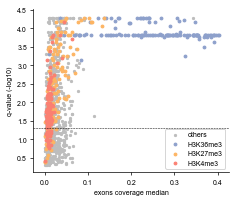

In [13]:
scores_df = pd.read_csv(path.join('results', "score_per_histon_mark_and_nucleosome_excluding_first_and_last.tsv"), sep="\t")
scores_df.drop_duplicates(inplace=True)

my_c_dict = dict()
my_c_dict['H3K36me3'] = '#8da0cb'
my_c_dict['H3K4me3'] = '#fb8072'
my_c_dict['H3K27me3'] = '#fdb462'

fig = plt.figure(figsize=(3.5, 3))

ax = plt.subplot(111)

# first plot other histone marks to move the gray dots in the background
xvalues = []
yvalues = []
for my_hist_mark in set(scores_df['hist_mark']):
    
    if my_hist_mark == 'nucleosomes':
        next
    
    sub_res = scores_df[scores_df['hist_mark'] == my_hist_mark]
    
    if my_hist_mark not in my_c_dict.keys():
        xvalues += list(sub_res['exons_cov_median'])
        yvalues += list(sub_res['q_value'])
        
my_c = '#bdbdbd'
ax.scatter(xvalues, -np.log10(yvalues), c=my_c, s=5, label='others') 

# now plot the histone marks of interest
for my_hist_mark in ['H3K36me3', 'H3K27me3', 'H3K4me3']:
    
    if my_hist_mark == 'nucleosomes':
        next
    
    sub_res = scores_df[scores_df['hist_mark'] == my_hist_mark]
    
    if my_hist_mark in my_c_dict.keys():
        
        my_c = my_c_dict[my_hist_mark]
        ax.scatter(sub_res['exons_cov_median'], -np.log10(sub_res['q_value']), c=my_c, s=8, label=my_hist_mark) 
        

ax.legend(fontsize=7)

ax.axhline(-np.log10(0.05), ls='--', color='black', lw=0.5)

ax.set_xlabel('exons coverage median')
ax.set_ylabel('q-value (-log10)')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(path.join('figures', 'figure1B.svg'), bbox_inches='tight')
plt.show()

## Sequences coverage

For each position in the exons (centered) compute the ratio of sequences covered by peaks of each chromatine feature in each cell type vs. the total number of sequences.

The data processing follows the **Exon-centerd and intron-centerd mutational analyses** section.

In [14]:
middle_distance_threshold = 2500

# Read exon coordinates and their middle values and usable ranges

#Read coordinates
exons_coords_df = pd.read_csv(middle_exons_coords, sep="\t", low_memory=False)
exons_coords_df.columns = ['chr', 'start', 'end', 'ensembl', 'gene', 'symbol']
exons_coords_df = exons_coords_df[['chr', 'start', 'end', 'ensembl']]
exons_coords_symbol_df = exons_coords_df

#Define middle of the exon
exons_coords_symbol_df['exon_size'] = (exons_coords_symbol_df['end']
                                   - exons_coords_symbol_df['start'])

exons_coords_symbol_df['exon_middle_start'] = (exons_coords_symbol_df['start']
                                             + exons_coords_symbol_df['exon_size']/2)

exons_coords_symbol_df['exon_middle_start'] = exons_coords_symbol_df.apply(lambda x:
                                                   math.floor(x['exon_middle_start']),
                                                   axis=1)

exons_coords_symbol_df['exon_middle_end'] = exons_coords_symbol_df['exon_middle_start'] + 1

#Expand 2500bp at each side
exons_coords_symbol_df['region_start'] = exons_coords_symbol_df['exon_middle_start'] - middle_distance_threshold
exons_coords_symbol_df['region_end'] = exons_coords_symbol_df['exon_middle_end'] + middle_distance_threshold

sub_exons_coords = exons_coords_symbol_df[['chr', 'region_start', 'region_end', 'ensembl',
                                      'exon_size', 'exon_middle_start',
                                      'exon_middle_end']]

sub_exons_coords_bed = pybedtools.BedTool.from_dataframe(sub_exons_coords)
n_exon_coords = len(sub_exons_coords_bed)

In [15]:
# Compute histone coverage per bp at the coordinates defined above. 

histon_cell = 'E075-H3K36me3'

histone_data_path = histone_data_folder + histon_cell + '.narrowPeak.gz'
histone_data_df = pd.read_csv(histone_data_path, sep='\t', header=None)

histone_data_df = histone_data_df[[0,1,2]]

histon_mark_bed = pybedtools.BedTool.from_dataframe(histone_data_df)

my_histon_intersec_bed = sub_exons_coords_bed.intersect(histon_mark_bed, wao=True)

histon_marks_in_range = pd.read_table(my_histon_intersec_bed.fn, names = ['range_chr', 'range_start', 'range_end',
                        'ensembl','region_size', 'region_middle_start', 'region_middle_end',
                        'hist_chr', 'hist_start', 'hist_end', 'overlap_bp'])

histon_marks_in_range['relative_start'] = histon_marks_in_range['hist_start'] - histon_marks_in_range['region_middle_start']
histon_marks_in_range['relative_end'] = histon_marks_in_range['hist_end'] - histon_marks_in_range['region_middle_start']

overlapping_histon_marks = histon_marks_in_range[histon_marks_in_range['overlap_bp'] != 0]

all_reads_in_range = (middle_distance_threshold*2+1)*[0]

total_region = len(histon_marks_in_range)

#Collapse all exons together by their middle position
for index, my_histon_row in tqdm(overlapping_histon_marks.iterrows()):

    range_start = my_histon_row.range_start
    range_end = my_histon_row.range_end

    hist_start = my_histon_row.hist_start
    hist_end = my_histon_row.hist_end

    middle_start = my_histon_row.region_middle_start
    middle_end = my_histon_row.region_middle_end

    overlap_start = max([range_start, hist_start])
    overlap_end = min([range_end, hist_end])

    relative_start = overlap_start - middle_start
    relative_end = overlap_end + 1 - middle_end

    initial_bases = relative_start - ( - middle_distance_threshold)
    middle_bases = relative_end - relative_start
    final_bases = middle_distance_threshold + 1 - relative_end

    initial_reads = [0]*initial_bases
    midle_reads = [1]*middle_bases
    final_reads = [0]*final_bases

    my_reads_in_range = initial_reads + midle_reads + final_reads

    a=all_reads_in_range
    b=my_reads_in_range

    all_reads_in_range = [x+y for x,y in zip(a,b)]

all_reads_in_range_df = pd.DataFrame(all_reads_in_range)

all_reads_in_range_df['position'] = list(range(- middle_distance_threshold,
                                           middle_distance_threshold + 1))

all_reads_in_range_df.columns = ['reads_count', 'position']
all_reads_in_range_df = all_reads_in_range_df[['position', 'reads_count']]

all_reads_in_range_df['reads_count'] = all_reads_in_range_df['reads_count']/n_exon_coords

exon_reads_in_range = all_reads_in_range_df.copy()
exon_reads_in_range.to_csv(path.join('results', "%s_exon.csv" % histon_cell), 
                           sep="\t", header=True, index=False)

241762it [04:23, 918.49it/s] 


### Panel c)

Internal exons-centered coverage of H3K36me3 peaks in primary cells of the normal colon mucosa (E075).

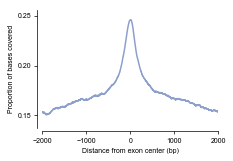

In [16]:
# Read the data from the computed files and make the plot

middle_distance_threshold = 2000

histon_cell = 'E075-H3K36me3'

exon_reads_in_range = pd.read_csv(path.join('results', "%s_exon.csv" % histon_cell), sep="\t", header=0)

my_max = max(exon_reads_in_range['reads_count'])
my_min = min(exon_reads_in_range['reads_count'])
my_diff = my_max-my_min
my_upper_lim  = my_max + my_diff/10
my_lower_lim = my_min - my_diff/10

fig = plt.figure(figsize=(3.25, 2.25))

# exon centered plot
ax = fig.add_subplot(111)

ax.margins(0.05)

ax.plot(exon_reads_in_range['position'], exon_reads_in_range['reads_count'], linewidth=1.5, color='#8da0cb')
ax.set_ylim(my_lower_lim, my_upper_lim)

ax.set_facecolor('none')

ax.set_frame_on(True)
# show the left spline
for axis in ['right', 'top']:
    ax.spines[axis].set_visible(False)

for axis in ['bottom', 'left']:
    ax.spines[axis].set_position(('axes', -0.03))

ax.xaxis.set_ticks_position('none') 
ax.tick_params(direction='out', pad=3)
ax.yaxis.set_ticks_position('left')
ax.yaxis.major.locator.set_params(nbins=4)
ax.xaxis.major.locator.set_params(nbins=4)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlim(-middle_distance_threshold, middle_distance_threshold)
plt.title('')
plt.xlabel('Distance from exon center (bp)')
plt.ylabel('Proportion of bases covered')


plt.xlabel('Distance from exon center (bp)')
plt.tight_layout()

plt.savefig(path.join('figures', 'figure1C.svg'))

plt.show()